In [1]:
%matplotlib inline

# Variance Partitioning

In [2]:
import numpy as np

from himalaya.backend import set_backend
from himalaya.kernel_ridge import KernelRidgeCV, MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from himalaya.kernel_ridge import ColumnKernelizer
from himalaya.utils import generate_multikernel_dataset

from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

In this example, we use the ``cupy`` backend (GPU).



In [3]:
backend = set_backend("cupy", on_error="warn")

/u/halle/schulthe/home_at/git/compare_variance_residual/.venv/lib/python3.10/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [4]:
n_kernels = 2
n_features_list = [1000]  * n_kernels
n_targets = 50
n_samples_train = 600
n_samples_test = 300

In [21]:
kernel_weights = [[0.9, 0.1]] * n_targets
kernel_weights = np.array(kernel_weights)

## Generate a random dataset
- X_train : array of shape (n_samples_train, n_features)
- X_test : array of shape (n_samples_test, n_features)
- Y_train : array of shape (n_samples_train, n_targets)
- Y_test : array of shape (n_samples_test, n_targets)

In [22]:
(X_train, X_test, Y_train, Y_test, kernel_weights, n_features_list) = generate_multikernel_dataset(n_kernels=n_kernels, n_features_list=n_features_list, n_targets=n_targets,
                                                                                                   n_samples_train=n_samples_train,
                                                                                                   n_samples_test=n_samples_test,
                                                                                                   kernel_weights=kernel_weights,
                                                                                                   random_state=42)
# projection on the simplex, making kernel weights sum to one.
kernel_weights = backend.to_numpy(kernel_weights)
kernel_weights[kernel_weights < 0] = 0.
kernel_weights /= np.sum(kernel_weights, 1)[:, None]

feature_names = [f"Feature space {ii}" for ii in range(len(n_features_list))]

# Variance Partitioning

## Single models

In [23]:
solver_params = dict()

single_pipelines = []
for feature in range(len(n_features_list)):
    single_model = KernelRidgeCV(alphas=np.logspace(-10, 10, 41), kernel="precomputed", solver="eigenvalues", solver_params=solver_params)
    
    pipe = make_pipeline(Kernelizer(), single_model)
    single_pipelines.append(pipe)

    # separate input kernels
    X_train_sub = np.split(X_train, indices_or_sections=2, axis=1)[feature]

    # Fit the model on single kernel targets
    pipe.fit(X_train_sub, Y_train)

### Compute prediction scores

In [24]:
import matplotlib.pyplot as plt

# predict for all targets
test_scores = []
for i, pipeline in enumerate(single_pipelines):
    score = pipeline.score(np.split(X_test, indices_or_sections=2, axis=1)[i], Y_test)
    score = backend.to_numpy(score)
    test_scores.append(score)

 ### Plot voxelwise R^2 scores

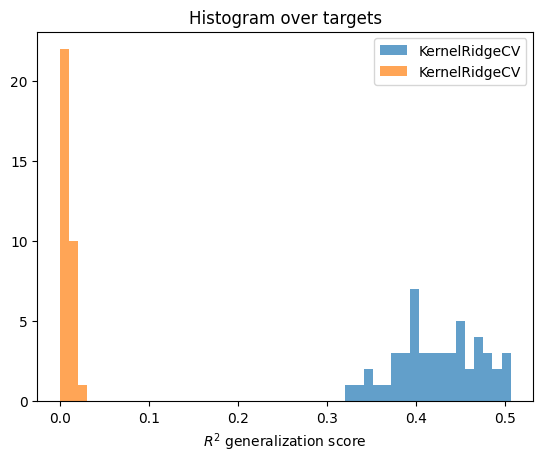

In [25]:
maximum = 0
for score in test_scores:
    maximum = max(maximum, score.max())

bins = np.linspace(0, maximum, 50)
for score in test_scores:
    plt.hist(score, bins, alpha=0.7, label="KernelRidgeCV")

plt.xlabel(r"$R^2$ generalization score")
plt.title("Histogram over targets")
plt.legend()
plt.show()

## Joint model

### Prepare the pipeline

In [15]:
# Find the start and end of each feature space X in Xs
start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
slices = [
    slice(start, end)
    for start, end in zip(start_and_end[:-1], start_and_end[1:])
]

# Create a different ``Kernelizer`` for each feature space.
kernelizers = [("space %d" % ii, Kernelizer(), slice_)
               for ii, slice_ in enumerate(slices)]
column_kernelizer = ColumnKernelizer(kernelizers)

### Define the random-search model
We use very few iteration on purpose, to make the random search suboptimal,
and refine it with hyperparameter gradient descent.



In [17]:
solver_params = dict(n_iter=5, alphas=np.logspace(-10, 10, 41))

model_1 = MultipleKernelRidgeCV(kernels="precomputed", solver="random_search",
                                solver_params=solver_params, random_state=42)
pipe_1 = make_pipeline(column_kernelizer, model_1)

# Fit the model on all targets
pipe_1.fit(X_train, Y_train)

[........................................] 100% | 4.00 sec | 5 random sampling with cv | 


Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed', random_state=42,
                                       solver_params={'alphas': array([1.00000000e-10, 3.16227766e-10, 1.000...
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06, 3.16227766e+06, 1.00000000e+07, 3.16227766e+07,
       1.00000000e+08, 3.16227766e+08, 1.00000000e+09, 3.16227766e+09,
       1.00000000e+10]),
                                                      'n_iter': 5}))])

### Define the gradient-descent model

In [18]:
solver_params = dict(max_iter=10, hyper_gradient_method="direct",
                     max_iter_inner_hyper=10,
                     initial_deltas="here_will_go_the_previous_deltas")

model_2 = MultipleKernelRidgeCV(kernels="precomputed", solver="hyper_gradient",
                                solver_params=solver_params)
pipe_2 = make_pipeline(column_kernelizer, model_2)

### Use the random-search to initialize the gradient-descent

In [33]:
# We might want to refine only the best predicting targets, since the
# hyperparameter gradient descent is less efficient over many targets.
top = 100  # top 60%
best_cv_scores = backend.to_numpy(pipe_1[-1].cv_scores_.max(0))
mask = best_cv_scores > np.percentile(best_cv_scores, 100 - top)
deltas = pipe_1[-1].deltas_
# deltas = deltas[:, mask]

pipe_2[-1].solver_params['initial_deltas'] = deltas
pipe_2.fit(X_train, Y_train[:, mask])

[........................................] 100% | 17.33 sec | hypergradient_direct | 


Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver='hyper_gradient',
                                       solver_params={'hyper_gradient_method': 'direct',
                                                      'initial_d...
        -1.3334848e+01, -1.0716631e+01, -3.6045067e+01, -1.0716631e+01,
        -2.2229557e+01, -1.2183556e+01, -3.7196358e+01, -3.7196358e+01,
        -1.1032263e+01, -3.7196358e+01, -1.3334848e+01, -3.7196358e+01,
        -2.3380850e+01, -1.3334848e+01, -1.3334848e+01, -1.2183556e+01,
        -1.3334848e+01, -3.4893776e+01, -1.2183556e+01, -1.2183556e+01,
        -3.6045067e+01, -1.2183556e+01]], dtype=float32),
                                                      'max_iter': 10,
                                                      'max_iter_inner_hyper': 10}))])

### Compute predictions on a test set

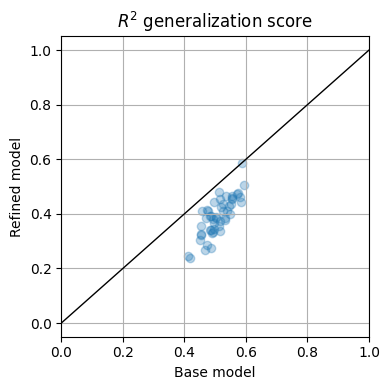

In [34]:
import matplotlib.pyplot as plt

# use the first model for all targets
test_scores_1 = pipe_1.score(X_test, Y_test)

# use the second model for the refined targets
test_scores_2 = backend.copy(test_scores_1)
test_scores_2[mask] = pipe_2.score(X_test, Y_test[:, mask])

test_scores_1 = backend.to_numpy(test_scores_1)
test_scores_2 = backend.to_numpy(test_scores_2)
plt.figure(figsize=(4, 4))
plt.scatter(test_scores_1, test_scores_2, alpha=0.3)
plt.xlim(0, 1)
plt.plot(plt.xlim(), plt.xlim(), color='k', lw=1)
plt.xlabel(r"Base model")
plt.ylabel(r"Refined model")
plt.title("$R^2$ generalization score")
plt.grid()
plt.tight_layout()
plt.show()

## Model comparison

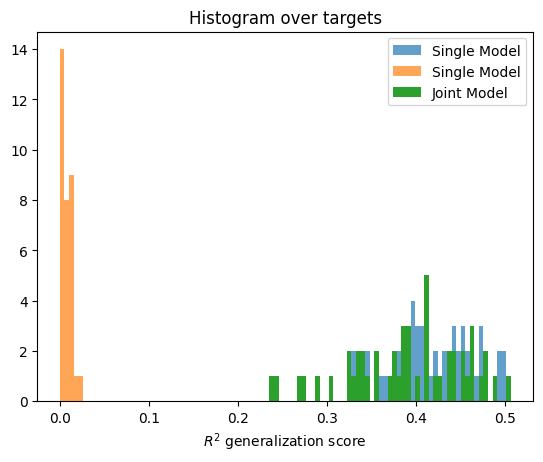

In [35]:
maximum = 0
for score in test_scores:
    maximum = max(maximum, score.max())

bins = np.linspace(0, maximum, 100)
for score in test_scores:
    plt.hist(score, bins, alpha=0.7, label="Single Model")
plt.hist(test_scores_2, bins, alpha=1., label="Joint Model")

plt.xlabel(r"$R^2$ generalization score")
plt.title("Histogram over targets")
plt.legend()
plt.show()